# pymoo

[pymoo](https://pymoo.org/) is a pure-python package for (constrained) single and multi-objective optimization with implementations of NSGA2, NSGA3, R-NSGA3, MOEAD, Genetic Algorithms (GA), Differential Evolution (DE) and CMA-ES.  
The following example is based on the excellent [getting-started guide](https://pymoo.org/getting_started.html).

In [1]:
import pymoo
print("pymoo version:", pymoo.__version__)

pymoo version: 0.4.1


## Example problem

In the following, we investigate the following custom toy problem with two variables, two objectives, two inequality constraints and box-bounds on the variables:

\begin{align}
\min \;\; & f_1(x) = (x_1^2 + x_2^2) \\
\min \;\; & f_2(x) = (x_1-1)^2 + x_2^2 \\
\text{s.t.} \;\; & g_1(x) = (x_1 - 0.1) \, (x_1 - 0.9) \leq 0\\
& g_2(x) = - (x_1 - 0.4) \, (x_1 - 0.6) \leq 0\\
& -2 \leq x_1 \leq 2 \\
& -2 \leq x_2 \leq 2
\end{align}

In the design space on the left the circular contours show the two objectives, which are minimal at the design points (0, 0) and (1, 0). The inequality constraints are independent of $x_2$ and constrain the design space to two disjoint regions $x_1 \in [0.1, 0.4] \cup [0.6, 0.9]$, thus excluding the minima of the individual objectives. The Pareto front (orange) is composed of the feasible points along $x_2 = 0$.

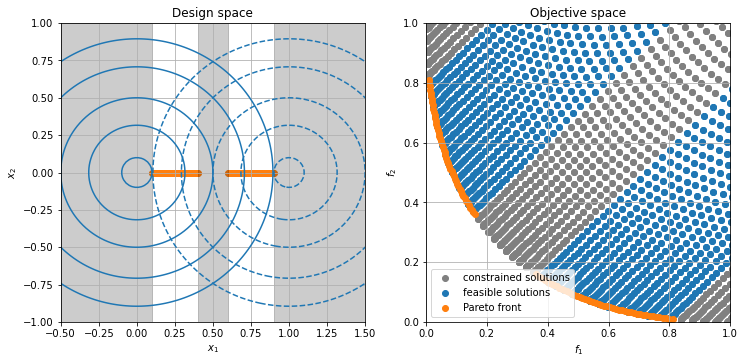

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

X1, X2 = np.meshgrid(np.linspace(-2, 2, 200), np.linspace(-2, 2, 200))
F1 = X1**2 + X2**2
F2 = (X1-1)**2 + X2**2
G1 = (X1 - 0.1) * (X1 - 0.9) <= 0
G2 = (X1 - 0.4) * (X1 - 0.6) >= 0
G = G1 * G2

x1 = np.r_[np.linspace(0.1, 0.4, 50), np.linspace(0.6, 0.9, 50)]
F_pareto = np.column_stack([x1**2, (x1 - 1)**2]) 
X_pareto = np.column_stack([x1, np.zeros_like(x1)])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5.5))

ax1.contour(X1, X2, F1, levels=[0.01, 0.1, 0.25, 0.5, 0.8], colors="C0")
ax1.contour(X1, X2, F2, levels=[0.01, 0.1, 0.25, 0.5, 0.8], colors="C0", linestyles="dashed")
ax1.scatter(*X_pareto.T, color="C1")
ax1.axvspan(-0.5, 0.1, color="black", alpha=0.2)
ax1.axvspan(0.4, 0.6, color="black", alpha=0.2)
ax1.axvspan(0.9, 1.5, color="black", alpha=0.2)
ax1.set(xlim=(-0.5, 1.5), ylim=(-1, 1), xlabel="$x_1$", ylabel="$x_2$", title="Design space")
ax1.grid()

ax2.scatter(F1[~G].flat, F2[~G].flat, color="gray", label="constrained solutions")
ax2.scatter(F1[G].flat, F2[G].flat, label="feasible solutions")
ax2.scatter(*F_pareto.T, color="C1", label="Pareto front")
ax2.set(xlim=(0, 1), ylim=(0, 1), xlabel="$f_1$", ylabel="$f_2$", title="Objective space")
ax2.legend()
ax2.grid();

## Problem definition

First we need to define the problem in suitable form. pymoo expects an object inheriting from the `pymoo.Problem` class
defining the number of variables, objectives and constraints as well as the lower and upper variable bounds. 
An `_evaluate` method needs to be implemented, returning the objective values and constraints for a given 2D input array, where rows represent individuals and columns the optimization variables. 
If the optimization algorithm requires gradients then the objectives and constraints evaluation needs to be implemented using `autograd.numpy` or `jax.numpy` so that auto-differentiation is available. 

If the Pareto front is known, methods for returning a representative set of Pareto-efficient objectives and their design variables can be implemented for calculating performance metrics such as the GD and IGD (see [performance metrics in multi-objective optimization](https://davidwalz.github.io/blog/multi-objective%20optimization/2020/04/12/multiobjective-metrics.html)).

In [3]:
import autograd.numpy as anp
from pymoo.util.misc import stack
from pymoo.model.problem import Problem

class MyProblem(Problem):

    def __init__(self):
        super().__init__(
            n_var=2, 
            n_obj=2, 
            n_constr=2, 
            xl=anp.array([-2, -2]), 
            xu=anp.array([2, 2])
        )

    def _evaluate(self, x, out, *args, **kwargs):
        x1, x2 = x.T
        f1 = x1 ** 2 + x2 ** 2
        f2 = (x1 - 1) ** 2 + x2 ** 2
        g1 = (x1 - 0.1) * (x1 - 0.9)
        g2 = - (x1 - 0.4) * (x1 - 0.6)
        out["F"] = anp.column_stack([f1, f2])
        out["G"] = anp.column_stack([g1, g2])

    def _calc_pareto_front(self, **kwargs):
        return F_pareto
    
    def _calc_pareto_set(self, **kwargs):
        return X_pareto
    
problem = MyProblem()

## Optimization with NSGA2

For this problem we use NSGA2 with a population size of 40 and 20 offsprings per generation and run the optimization for 20 generations.

In [4]:
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation, get_termination
from pymoo.optimize import minimize

algorithm = NSGA2(
    pop_size=40,
    n_offsprings=20,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx", prob=0.9, eta=15),
    mutation=get_mutation("real_pm", eta=20),
    eliminate_duplicates=True  # enforce different x in offsprings
)

results = minimize(
    problem,
    algorithm,
    get_termination("n_gen", 20),
    seed=1,
    pf=problem.pareto_front(use_cache=False),
    save_history=True,
    verbose=True)

n_gen |  n_eval |   cv (min)   |   cv (avg)   |     igd      |      gd      |      hv     
    1 |      40 |  0.00000E+00 |  2.127592675 |  0.371356142 |  0.005050920 |  0.259340233
    2 |      60 |  0.00000E+00 |  0.628476009 |  0.324252203 |  0.012430471 |  0.270122298
    3 |      80 |  0.00000E+00 |  0.184152759 |  0.324252203 |  0.012430471 |  0.270122298
    4 |     100 |  0.00000E+00 |  0.028391220 |  0.304520050 |  0.012120037 |  0.286513525
    5 |     120 |  0.00000E+00 |  0.000070397 |  0.129701172 |  0.013148155 |  0.394301235
    6 |     140 |  0.00000E+00 |  0.00000E+00 |  0.082573274 |  0.008509504 |  0.420544450
    7 |     160 |  0.00000E+00 |  0.00000E+00 |  0.042216189 |  0.011916880 |  0.429691203
    8 |     180 |  0.00000E+00 |  0.00000E+00 |  0.026195804 |  0.009698708 |  0.438965563
    9 |     200 |  0.00000E+00 |  0.00000E+00 |  0.024178303 |  0.009473878 |  0.441918959
   10 |     220 |  0.00000E+00 |  0.00000E+00 |  0.022104178 |  0.010557633 |  0.442208886

With `verbose=True` the progress in terms of hypervolume (using the observed nadir as reference point), and the (inverted) generational distance are listed, if the pareto front was provided as part of the problem definition. However, the metrics are not saved in the results object, so we have to recompute them below.

## Results

Looking at the last generation we can see that the algorithm was able to converge, and a set of nearly-optimal solutions was obtained (black crosses). 

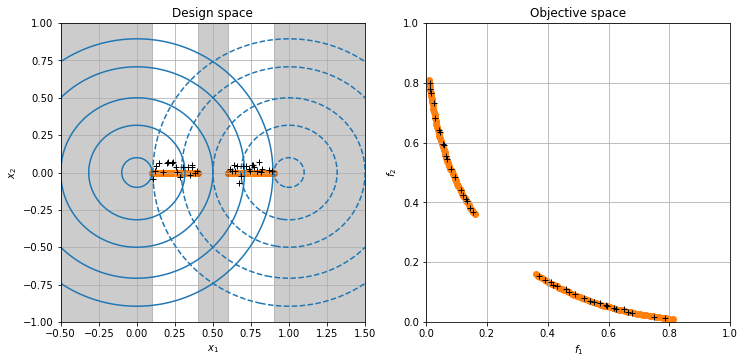

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5.5))

ax1.contour(X1, X2, F1, levels=[0.01, 0.1, 0.25, 0.5, 0.8], colors="C0")
ax1.contour(X1, X2, F2, levels=[0.01, 0.1, 0.25, 0.5, 0.8], colors="C0", linestyles="dashed")
ax1.scatter(*X_pareto.T, color="C1")
ax1.axvspan(-0.5, 0.1, color="black", alpha=0.2)
ax1.axvspan(0.4, 0.6, color="black", alpha=0.2)
ax1.axvspan(0.9, 1.5, color="black", alpha=0.2)
ax1.set(xlim=(-0.5, 1.5), ylim=(-1, 1), xlabel="$x_1$", ylabel="$x_2$", title="Design space")
ax1.grid()

ax2.scatter(*F_pareto.T, color="C1")
ax2.set(xlim=(0, 1), ylim=(0, 1), xlabel="$f_1$", ylabel="$f_2$", title='Objective space')
ax2.grid()

ax1.plot(*results.X.T, 'k+')
ax2.plot(*results.F.T, 'k+');

Since we stored the history of the optimization run we can now analyze the convergence over time.
Plotting HV, GD and IGD for each generation, we see that the population converged to a good approximation of the Pareto front after less than 10 generations.

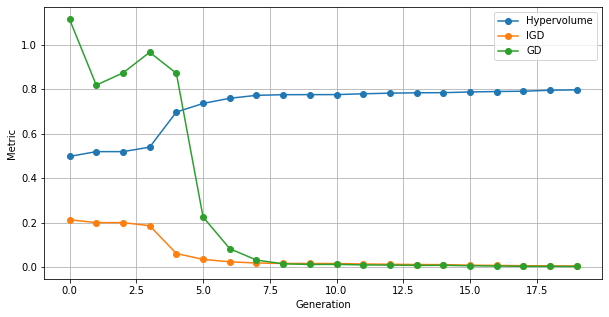

In [6]:
from pymoo.performance_indicator.hv import Hypervolume
from pymoo.factory import get_performance_indicator

pops = [a.pop for a in results.history]  # collect the population in each generation
objs = [pop[pop.get("feasible")[:,0]].get("F") for pop in pops]  # collect the (feasible) objective values

hv = [Hypervolume(ref_point=np.array([1.0, 1.0])).calc(A) for A in objs]
igd = [get_performance_indicator("igd+", F_pareto).calc(A) for A in objs]
gd = [get_performance_indicator("gd+", F_pareto).calc(A) for A in objs]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(hv, '-o', label='Hypervolume')
ax.plot(igd, '-o', label='IGD')
ax.plot(gd, '-o', label='GD')
ax.legend();
ax.set(xlabel="Generation", ylabel='Metric')
ax.grid();

pymoo was written from scratch by a "hero developer" Julian Blanc at the Computational Optimization and Innovation Laboratory (COIN) at the Michigan State University supervised by Kalyanmoay Deb.
The code looks highly maintainable and clean compared to e.g. pygmo. 
However, it will need to be seen if the main developer will continue to maintain the package or a sustainable community can be built around it. 